In [3]:
# File System
import os, sys, pickle as pkl
from os import path as pth
import itertools as it

# Plotting
from matplotlib import pyplot as plt
from matplotlib import ticker as mticker

# Math
import numpy as np
from numpy import linalg as la
import pandas as pd
pd.options.mode.chained_assignment = None

from scipy.stats import norm, uniform, multivariate_normal
import scipy.optimize as opt
from functools import reduce, partial

# Display
from IPython.display import clear_output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from Model import TwoSignal
from mcmc import MHMCMC

from corner import corner

data_path = "data"

In [390]:
class IterMinMCMC(MHMCMC):
    def selection(self):
        qs = self.proposal()
        r = uniform.rvs(0,1)
                   
        if (self.f(self.x) - self.f(np.array(qs)) > np.log(r)):
            self.x = qs

        return self.x
        

### Problem 1

In [610]:
with open(pth.join(data_path, 'dataset11.pkl'), 'rb') as f:
    d = pkl.load(f)

In [702]:
sig2 = TwoSignal(100, 257.4, np.zeros(5), d)
sig2.set_params(sig2.analytic_params()[0])
_=opt.minimize(lambda p: TwoSignal.with_period_param(100, p, d).negloglike()
             , np.array([sig2.T2, *sig2.params]))

In [705]:
def param_prior(p):
    T = period_prior(p[0])
    dc = dc_prior(p[1])
    amp1 = amp1_prior(p[2:4])
    amp2 = amp2_prior(p[4:6])
    
    return -np.sum(np.log([T, dc, amp1, amp2]))

period_prior = lambda p: norm(sig2.T2, 0.21).pdf(p)
dc_prior = lambda p: norm(sig2.DC ,0.5).pdf(p)
amp1_prior = lambda p: norm(loc = sig2.amplitude[0], scale=0.1).pdf(np.sqrt(np.sum(np.power(p, 2))))
amp2_prior = lambda p: norm(loc = sig2.amplitude[1], scale=0.1).pdf(np.sqrt(np.sum(np.power(p, 2))))

In [707]:
prbm1_q = lambda p: norm.rvs(loc=p, scale=1e-2)
prbm1_f = lambda p: param_prior(p) + TwoSignal.with_period_param(100, p, data=d).negloglike()

MC = IterMinMCMC(prbm1_f, prbm1_q, init_x=np.array([sig2.T2, *sig2.params]))

In [708]:
K = 10_000

samples = MC.sample(K)
sample_array = np.array(samples)

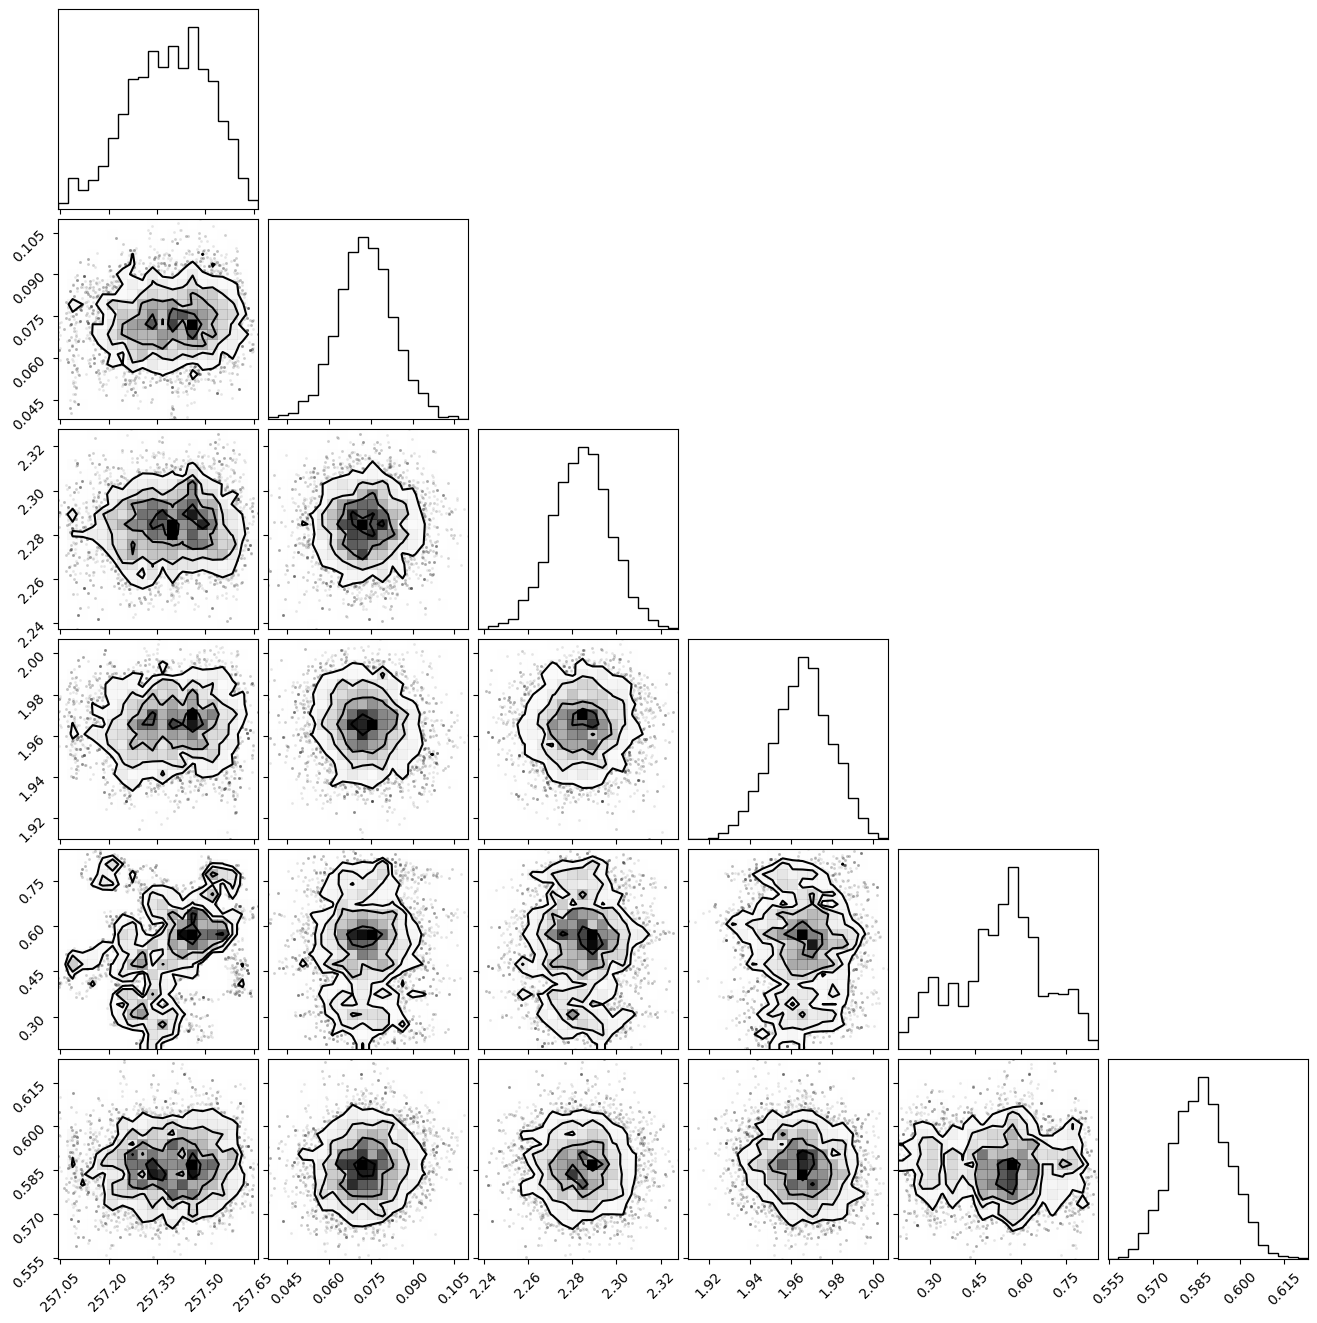

In [788]:
_ = corner(samples)

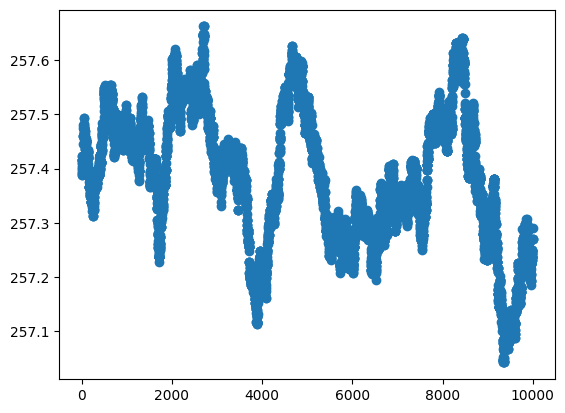

In [763]:
_ = plt.scatter(range(sample_array.shape[0]), sample_array[:,0])
# plt.ylim(2.5756, 2.5758)

In [718]:
sig = TwoSignal.with_period_param(100, np.mean(sample_array, axis=0), d)

MCMC Average negloglike: 469.0389276349 optimized negloglike: 469.5230015929734
Second Period: 257.39 ± 0.12 DC Level: 0.0731 ± 0.01 Amplitude 1: 3.01 ± 0.014 Amplitude 2: 0.792 ± 0.094


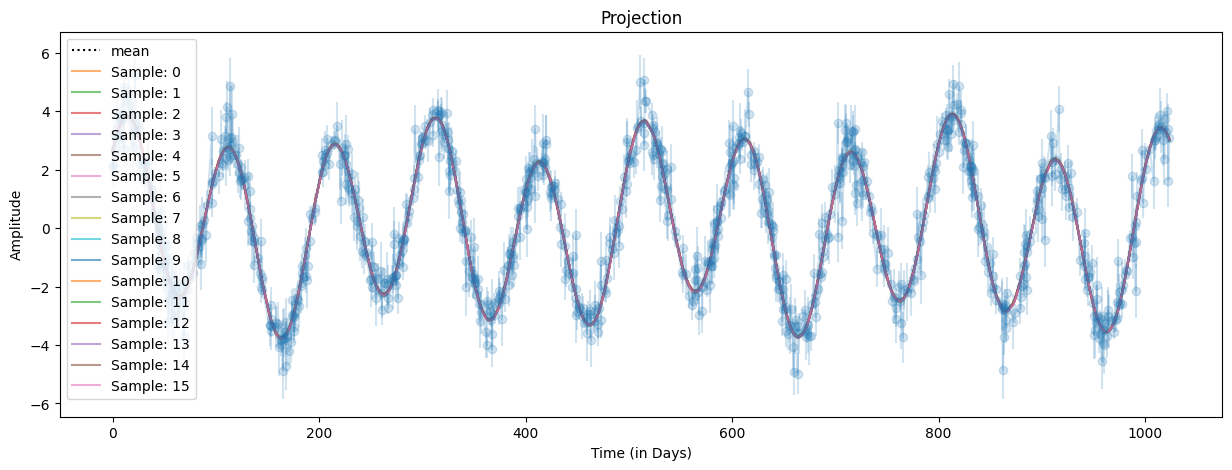

In [786]:
print(f"MCMC Average negloglike: {sig.negloglike()} optimized negloglike: {sig2.negloglike()}")

amp1_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,2:4], 2), axis=1)))
amp2_std = np.std(np.sqrt(np.sum(np.power(sample_array[:,4:6], 2), axis=1)))

print(f"Second Period:{sig.T2: .5} \u00B1{np.std(samples[:,0]): .2}"
      ,f"DC Level:{sig.DC: .3} \u00B1{np.std(samples[:,1]): .2}"
      ,f"Amplitude 1:{sig.amplitude[0]: .3} \u00B1{amp1_std: .2}"
      ,f"Amplitude 2:{sig.amplitude[1]: .3} \u00B1{amp2_std: .2}")

fig, ax = plt.subplots(1,1, figsize=(15,5))
_ = ax.errorbar(d.time, d.data, yerr=d.σy, marker="o", alpha=0.2)
_ = ax.plot(d.time, sig.pred(d.time), "k:", label="mean")

for ix, s in enumerate(np.random.choice(range(samples.shape[0]), size=16, replace=False)):
    _ = ax.plot(d.time, TwoSignal(100, samples[s,0], np.array(samples[s,1:]), d).pred(d.time)
                , label=f"Sample: {ix}", alpha=0.6)

_ = ax.set_title("Projection")
_ = ax.set_xlabel("Time (in Days)")
_ = ax.set_ylabel("Amplitude")
_ = plt.legend()